# 뉴스 요약봇 만들기

In [212]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import tensorflow as tf
import urllib.request

### Step 1. 데이터 수집하기

In [213]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

print('전체 데이터 수 :', (len(data)))
data.sample(10)

전체 데이터 수 : 98401


,headlines,text
53652,Jasprit Bumrah becomes India's 290th Test player,Pacer Jasprit Bumrah became India's 290th Test...
62545,Invasion of N Korea only way to destroy its nu...,"A ground invasion is the ""only way"" to locate ..."
25512,"No competition with Sara, she holds great prom...","Actress Janhvi Kapoor, while speaking about co..."
27977,Education Minister has apologised: Suspended U...,The Uttarakhand teacher who was suspended by C...
21488,"India gifts 30 ambulances, 6 buses to Nepal on...",India gifted 30 ambulances and six buses to Ne...
95697,"Govt aimed to build 15K km roads in 2016-17, b...","The government, which had aimed to build 15,00..."
34048,Ishaan has arrived like no newcomer has: Mom N...,"Actress Neelima Azim, while talking about her ..."
49562,What a guy: Anushka on Kohli's ODI century in ...,Actress Anushka Sharma shared a series of pict...
39481,WhatsApp founders gave up $1.3 bn after rift w...,WhatsApp Co-founders Brian Acton and Jan Koum ...
95851,Akshay Kumar shares first poster of 'Toilet: E...,Actor Akshay Kumar took to Twitter to share th...




### Step 2. 데이터 전처리하기 (추상적 요약)



In [214]:
# 중복 샘플 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('중복 제거 후 전체 데이터 수 :', (len(data)))

중복 제거 후 전체 데이터 수 : 98360


In [215]:
#  NULL 체크
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


*데이터 정규화*

In [216]:
# 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                "you're": "you are", "you've": "you have"}

print("정규화 사전의 단어 개수: ", len(contractions))

정규화 사전의 단어 개수:  120


In [217]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all

In [218]:
from bs4 import BeautifulSoup 

# 데이터 정규화 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [219]:
from tqdm import tqdm

clean_text = []
for s in tqdm(data['text']):
    clean_text.append(preprocess_sentence(s))

print("\ntext 전처리 후 결과: ", clean_text[:5])

100%|██████████| 98360/98360 [09:29<00:00, 172.73it/s]


text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insu

In [220]:
clean_headlines = []
for s in tqdm(data['headlines']):
    clean_headlines.append(preprocess_sentence(s, False))

print("\nheadlines 전처리 후 결과: ", clean_headlines[:5])

100%|██████████| 98360/98360 [00:17<00:00, 5729.21it/s]


headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [221]:
# 정규화된 데이터로 업데이트
data['headlines'] = clean_headlines
data['text'] = clean_text

In [72]:
# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.isnull().sum()

headlines    0
text         0
dtype: int64

*데이터 최대 길이 정하기*

text 최소 길이 : 1
text 최대 길이 : 60
text 평균 길이 : 35.09968483123221

headlines 최소 길이 : 1
headlines 최대 길이 : 16
headlines 평균 길이 : 9.299532330215534



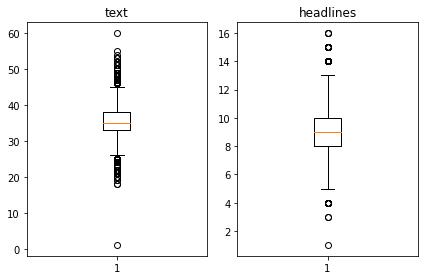

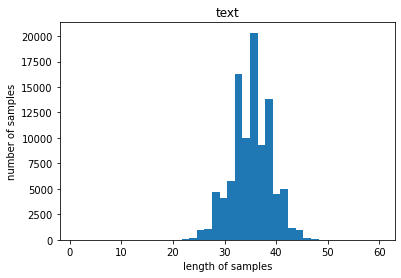

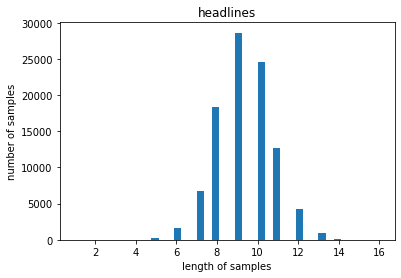

In [225]:
text_len = [len(s.split()) for s in data['text']]
print('text 최소 길이 : {}'.format(np.min(text_len)))
print('text 최대 길이 : {}'.format(np.max(text_len)))
print('text 평균 길이 : {}\n'.format(np.mean(text_len)))

headlines_len = [len(s.split()) for s in data['headlines']]
print('headlines 최소 길이 : {}'.format(np.min(headlines_len)))
print('headlines 최대 길이 : {}'.format(np.max(headlines_len)))
print('headlines 평균 길이 : {}\n'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')

plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')

plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [144]:
# 설정된 최대 길이보다 클 경우 데이터에서 제외
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1

In [145]:
text_max_len = 60
headlines_max_len = 16

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

In [148]:
# 시작 및 종료 토큰 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [151]:
# 모델 훈련에 사용할 데이터 변수
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

*데이터셋 분리하기*

In [167]:
# encoder_input과 크기와 형태가 같으며 순서가 섞인 '정수 시퀀스'
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

In [168]:
# '정수 시퀀스'를 이용해 데이터 재설정
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [169]:
# 2:8 비율로 분리
n_of_val = int(len(encoder_input)*0.2)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


*정수 인코딩*

In [170]:
src_tokenizer = tf.keras.preprocessing.text.Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [160]:
threshold = 6
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69428
등장 빈도가 5번 이하인 희귀 단어의 수: 45421
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24007
단어 집합에서 희귀 단어의 비율: 65.42173186610589
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.073364655908043


In [171]:
src_vocab = 24000
src_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [172]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [173]:
target_tokenizer = tf.keras.preprocessing.text.Tokenizer()
target_tokenizer.fit_on_texts(decoder_input_train)

In [174]:
threshold = 6
total_cnt = len(target_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in target_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30143
등장 빈도가 5번 이하인 희귀 단어의 수: 19771
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10372
단어 집합에서 희귀 단어의 비율: 65.59068440433931
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.680233598329819


In [175]:
target_vocab = 10000
target_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=target_vocab) 
target_tokenizer.fit_on_texts(decoder_input_train)
target_tokenizer.fit_on_texts(decoder_target_train)

In [177]:
decoder_input_train = target_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = target_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = target_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = target_tokenizer.texts_to_sequences(decoder_target_test)

In [178]:
# 빈도가 낮은 단어로 구성되어 삭제된 (길이 == 1) 데이터 제외
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78687
훈련 레이블의 개수 : 78687
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [179]:
# 데이터 길이 맞추기 : 패딩
encoder_input_train = tf.keras.preprocessing.sequence.pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = tf.keras.preprocessing.sequence.pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = tf.keras.preprocessing.sequence.pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = tf.keras.preprocessing.sequence.pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = tf.keras.preprocessing.sequence.pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = tf.keras.preprocessing.sequence.pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')



### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)



*(훈련) 모델 설계*

In [188]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


embedding_dim = 128
hidden_size = 256

# Encoder
encoder_inputs = Input(shape=(text_max_len,))

# Embedding Layer
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [190]:
# Decoder
decoder_inputs = Input(shape=(None,))

# Embedding Layer
dec_emb_layer = Embedding(target_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [192]:
# Attention Layer
attn_layer = tf.keras.layers.AdditiveAttention(name='attention_layer')

# Encoder와 Decoder의 모든 time step에 대한 hidden state를 Attention Layer에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# Attention 결과와 Decoder의 hidden state 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

In [193]:
# Output Layer
decoder_softmax_layer = Dense(target_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

In [194]:
# 모델 정의
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 60, 128)      3072000     ['input_5[0][0]']                
                                                                                                  
 lstm_8 (LSTM)                  [(None, 60, 256),    394240      ['embedding_4[0][0]']            
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

*모델 훈련*

In [195]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 371s 1s/step - loss: 4.2757 - val_loss: 3.9194
Epoch 2/50
308/308 [==============================] - 368s 1s/step - loss: 3.8145 - val_loss: 3.6467
Epoch 3/50
308/308 [==============================] - 367s 1s/step - loss: 3.5521 - val_loss: 3.4539
Epoch 4/50
308/308 [==============================] - 522s 2s/step - loss: 3.3496 - val_loss: 3.2910
Epoch 5/50
308/308 [==============================] - 631s 2s/step - loss: 3.1909 - val_loss: 3.1859
Epoch 6/50
308/308 [==============================] - 629s 2s/step - loss: 3.0612 - val_loss: 3.1013
Epoch 7/50
308/308 [==============================] - 629s 2s/step - loss: 2.9528 - val_loss: 3.0495
Epoch 8/50
308/308 [==============================] - 633s 2s/step - loss: 2.8565 - val_loss: 2.9807
Epoch 9/50
308/308 [==============================] - 631s 2s/step - loss: 2.7725 - val_loss: 2.9370
Epoch 10/50
308/308 [==============================] - 630s 2s/step - loss: 2.6993 - val_lo

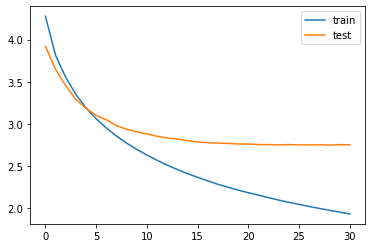

In [197]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()



### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)



*(추론) 모델 설계*

*1) Encoder*

In [198]:
# 모델 정의
encoder_model = tf.keras.models.Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

*2) Decoder*

In [199]:
# 이전 시점의 상태들을 저장
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

# Embedding Layer
dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용
# 훈련 과정에서와 달리 LSTM의 은닉 상태(state_h)와 셀 상태(state_c) 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention Layer
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Output Layer
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 모델 정의
decoder_model = tf.keras.models.Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [200]:
src_index_to_word = src_tokenizer.index_word # text 정수 -> 단어
target_word_to_index = target_tokenizer.word_index # headlines 단어 -> 정수
target_index_to_word = target_tokenizer.index_word # headlines 정수 -> 단어

In [201]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = target_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태 업데이트
        e_h, e_c = h, c

    return decoded_sentence

In [202]:
# text 정수 -> 텍스트 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# headlines 정수 -> 텍스트 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=target_word_to_index['sostoken']) and i!=target_word_to_index['eostoken']):
            temp = temp + target_index_to_word[i] + ' '
    return temp

*요약문 비교*

In [203]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : world expensive footballer neymar said five time ballon winner cristiano ronaldo joined juventus million change italian football football legend genius italian football watched child neymar added ronaldo scored goals matches nine year spell real madrid 
실제 요약 : ronaldo is genius will change italian football neymar 
예측 요약 :  neymar wanted to be named other neymar


원문 : telangana government allotted square yard plot badminton player pv sindhu winning silver medal rio olympics following sindhu olympic medal telangana government presented shuttler cash reward crore announced allotment residential plot hyderabad along government job offer 
실제 요약 : telangana allots sq plot to pv sindhu for rio silver 
예측 요약 :  sindhu wins silver at world para athletics sindhu


원문 : supreme court thursday refused give urgent hearing karti chidambaram request travel abroad november saying go stay back india karti matter taken tomorrow karti probed allegedly obtaining foreign investment clearances aircel



### Step 5. Summa을 이용해서 추출적 요약해보기



In [207]:
import requests
from summa.summarizer import summarize

In [208]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [209]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [224]:
print('Summary:')
print(summarize(text, ratio=0.01, split=True))

Summary:
['Trinity takes Neo to Morpheus.', 'Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Morpheus, who is above Neo in the walls, breaks through the wall and lands on the agent, yelling to Trinity to get Neo out of the building.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [223]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


*추상적 요약 vs 추출적 요약*

1. 새로운 문장을 생성함으로써 풍부한 표현력을 갖춘 **추상적 요약 방식**의 문장에서 더 자연스럽고 매끄러운 느낌을 받는다. 다시 말해면, 추출적 요약 방식에 비해 **'문법적인 완성도'**가 더 높다고 판단할 수 있다.

2. 요약 문장 내 **'핵심 단어 포함'** 여부의 관점에서는 원문에서 사용된 텍스트를 그대로 사용하는 **추출적 요약 방식**이 더 좋은 성능을 보인다고 판단할 수 있다.



---



### 회고

**추상적 요약 방식**과 관련해 공부하고 실습한 내용들 중 아래의 내용들이 특히 기억에 남는다.

* 데이터 전처리
: 중복 제거, 정규화, 최대 길이 설정 및 패딩

* 정수 인코딩
: Tokenizer 활용 방법

* 모델 설계
: Encoder, Decoder, Attention 구조 및 역할

* 테스트 (추론)
: 훈련 모델 vs 추론 모델 차이

단, 결과물인 요약 문장을 봤을 때 여전히 어색하다고 느낄만한 구석이 없지 않다. Train loss(1.9339)와 Validation loss(2.7527) 간 차이를 줄이고 나아가 모델 설계 단계에서 파라미터 조정 등 성능 향상을 위해 추가적인 작업이 필요했지만, 이와 관련해 어떤 것이 올바르고 또 효율적인지 아직은 정확한 판단이 서지 않아 실행해보지 못한 점은 아쉽다.